In [1]:
temperatures=read.table("../datasets/avtemp.csv", TRUE, sep=",")
colnames(temperatures)

[1] "year"     "tempdiff"

In [2]:
head(temperatures,5)

year,tempdiff
1880,-0.19
1881,-0.10
1882,-0.10
1883,-0.19
1884,-0.28


In [3]:
years=temperatures$year
temps=temperatures$tempdiff

n = nrow(temperatures)
index = sample(1:n,round(0.75*n))
train=temperatures[index,]
test=temperatures[-index,]

## Do a linear fit

In [4]:
lm.fit = lm(tempdiff~year, data=train)
print(summary(lm.fit))


Call:
lm(formula = tempdiff ~ year, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.34394 -0.11760 -0.01967  0.11176  0.46221 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.435e+01  8.197e-01  -17.51   <2e-16 ***
year         7.382e-03  4.201e-04   17.57   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.17 on 102 degrees of freedom
Multiple R-squared:  0.7517,	Adjusted R-squared:  0.7493 
F-statistic: 308.8 on 1 and 102 DF,  p-value: < 2.2e-16



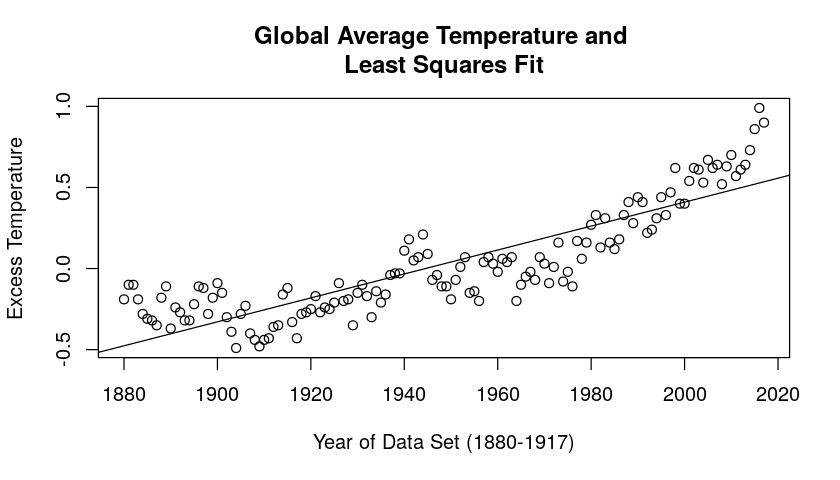

In [5]:
options(repr.plot.width=7, repr.plot.height=4)

#pdf("global-temp-plot-with-abline.pdf")
plot(years,temps, xlab="Year of Data Set (1880-1917)", 
     ylab="Excess Temperature",
    main="Global Average Temperature and 
Least Squares Fit")

abline(lm.fit)
#dev.off()

## Typical polynomial fit - e.g., 4th degree

In [6]:
lm.fit.4 = lm(tempdiff~poly(year,4), data=train)
summary(lm.fit.4)


Call:
lm(formula = tempdiff ~ poly(year, 4), data = train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.240704 -0.081744  0.004493  0.071366  0.296945 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.04769    0.01099   4.342 3.42e-05 ***
poly(year, 4)1  2.98706    0.11203  26.664  < 2e-16 ***
poly(year, 4)2  1.24040    0.11203  11.072  < 2e-16 ***
poly(year, 4)3  0.16029    0.11203   1.431  0.15562    
poly(year, 4)4  0.37498    0.11203   3.347  0.00115 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.112 on 99 degrees of freedom
Multiple R-squared:  0.8953,	Adjusted R-squared:  0.8911 
F-statistic: 211.7 on 4 and 99 DF,  p-value: < 2.2e-16


## Generate predictions and plot results

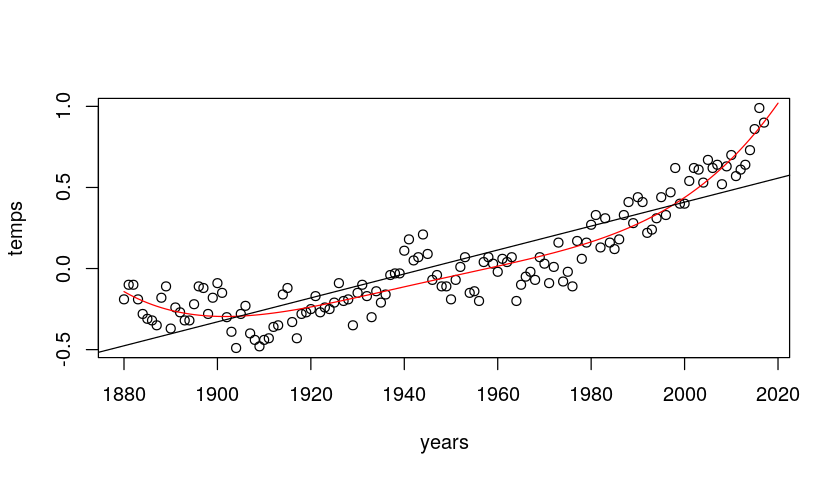

In [7]:
year=1880:2020
xvals=data.frame(year)

y4vals=predict(lm.fit.4, newdata=xvals)
plot(years,temps)
lines(year,y4vals,col="red")
abline(lm.fit)

## Set aside "observed" data 

In [8]:
#ntest=nrow(test)
observed = test$tempdiff

## function to calculate RSS

In [9]:
RSS=function(model, observed, data){
    predicted=predict(model, data)
    sum((observed-predicted)^2)
}

## Get RSS for linear fit

In [10]:
RSS(lm.fit, test$tempdiff, test)

[1] 0.7904698

## Get RSS for polynomial 

In [12]:
RSS(lm.fit.4, test$tempdiff, test)

[1] 0.4112621

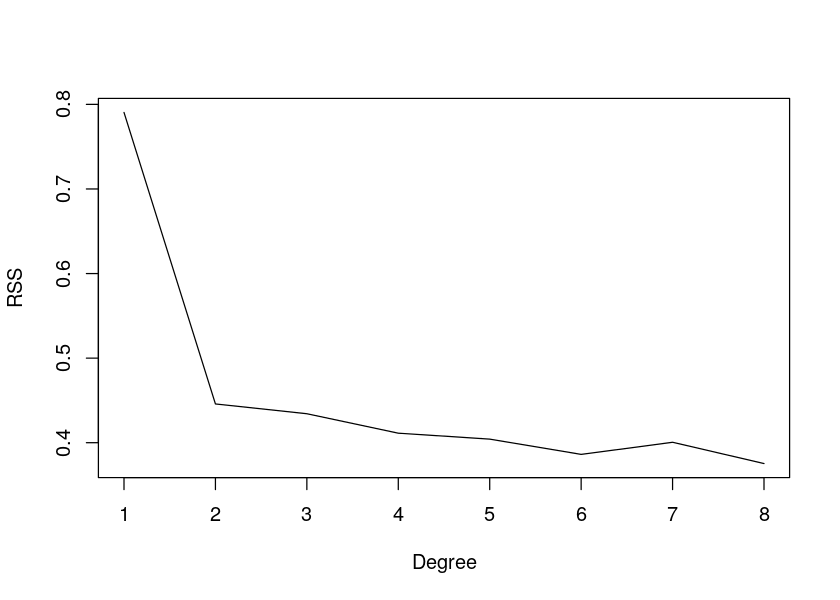

In [16]:
r2vals=0
dmax=8
r2vals[1] = RSS(lm.fit, test$tempdiff, test)
for (degree in 2:dmax) {
    model = lm(tempdiff~poly(year,degree), data=train)
    r2vals[degree]=RSS(model, test$tempdiff, test)
    }
options(repr.plot.width=7, repr.plot.height=5)
#pdf("RSS-temperature-fit.pdf",width=7,height=4)
plot(1:dmax, r2vals,type="l", #ylim=c(.7,.95), xlim=c(0, dmax),
    xlab="Degree",ylab="RSS")
#dev.off()
#axis(side=1,at=seq(.7,1,by=0.05))
#axis(side=2,at=seq(0, 20, by=5))
#abline(h=seq(.75,.85,by=0.05),v=seq(0, 20, 5), lwd=.5)


In [17]:

n = nrow(temperatures)
index = sample(1:n,round(0.75*n))
train=temperatures[index,]
test=temperatures[-index,]


RSSVALS=function(maxdegree, train, test){
    dmax=maxdegree
    results=rep(0, maxdegree)
    model=lm(tempdiff~year, data=train)
    results[1] = RSS(model, test$tempdiff, test)
    for (degree in 2:dmax) {
        model = lm(tempdiff~poly(year,degree), data=train)
        results[degree]=RSS(model, test$tempdiff, test)
    }
    results
}
RSSVALS(15, train, test)

[1] 0.9850681 0.3794355 0.3757018 0.2839569 0.2614345 0.2792085 0.3068706
 [8] 0.3124492 0.3207075 0.3143220 0.3130938 0.3181772 0.3222316 0.2788481
[15] 0.2891940

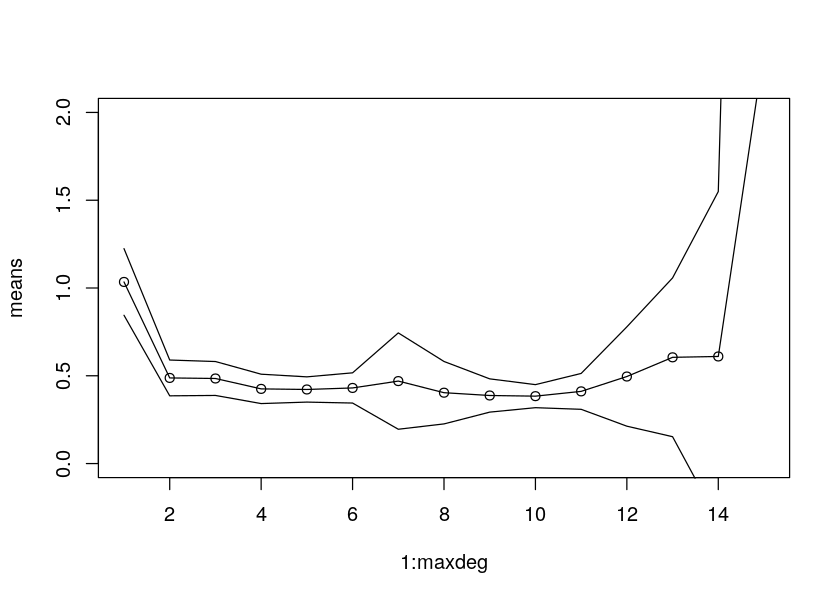

In [18]:
nsplits = 20
maxdeg=15
RSSTOT=rep(0,maxdeg)
for (j in 1:nsplits){
    n = nrow(temperatures)
    index = sample(1:n,round(0.75*n))
    train=temperatures[index,]
    test=temperatures[-index,] 
    rss = RSSVALS(maxdeg, train, test)
    RSSTOT = rbind(RSSTOT, rss)
    #print(R)
}
RSSTOT=RSSTOT[-1,]
means=colMeans(RSSTOT)
sds=apply(RSSTOT, 2, sd)

plot(1:maxdeg, means, type="l", ylim=c(0,2))
points(1:maxdeg, means)
lines(1:maxdeg, means+sds)
lines(1:maxdeg, means-sds)

In [19]:
pdf("temperature-fits-RSS-variation.pdf", height=4, width=7)
plot(1:maxdeg, means, type="l", ylim=c(0,2), xlab="degree of fit")
points(1:maxdeg, means)
lines(1:maxdeg, means+sds)
lines(1:maxdeg, means-sds)
dev.off()

png 
  2

##  Instead of accruing the RSS, just plot the results

In [ ]:
#pdf("temperature-poly-fits.pdf")
plot(years,temps, 
    xlab="Year",
    ylab="Excess Temperature",
    main="Global Average Temperature")
abline(lm.fit)
cc=sample(colors(),20)
year=1880:2017
xvals=data.frame(year)
for (degree in 2:20) {
    model = lm(tempdiff~poly(year,degree), data=train)
    ynewvals=predict(model, newdata=xvals)
    lines(year,ynewvals,col=cc[degree])
    }


## Optional Generate a randomized data set

In [ ]:
p = function(x){x*(x-1)*(1.5-x)*(x-3)}
x = seq(-.1,2.7,by=.01) 
y = p(x)+ rnorm(length(x),mean=0,sd=.125)
x = x + .2*runif(length(x))
dataset=data.frame(x,y)
plot(x,y,cex=.5)

ind=sample(1:length(x),.75*length(x))
train=dataset[ind,]
test=dataset[-ind,]


In [ ]:

dmax=8
r2vals=rep(0,dmax)
lm.fit=lm(y~x, train)
r2vals[1] = RSS(lm.fit, test$y, test)
for (degree in 2:dmax) {
    model = lm(y~poly(x,degree), data=train)
    r2vals[degree]=RSS(model, test$y, test)
    }
options(repr.plot.width=7, repr.plot.height=5)

plot(1:dmax, r2vals,type="l",
    xlab="Degree",ylab="RSS")
points(1:dmax, r2vals)

In [ ]:
rep(5,3)